COVID-19 Global Analysis & Machine Learning Prediction Project

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("Set2")

print(" COVID-19 Global Analysis Project")
print("=" * 50)

 COVID-19 Global Analysis Project


In [70]:
# ============================================================================
# 1. DATA LOADING AND CLEANING
# ============================================================================
from google.colab import files
import pandas as pd
import numpy as np # Added import for numpy

# Upload the file
uploaded = files.upload()  # This will open a file dialog in Colab

# Assume the uploaded file is a TSV (tab-separated) based on previous successful load
for filename in uploaded.keys():
    print(f" Uploaded file: {filename}")
    try:
        # Attempt to read with tab separator first
        covid_data = pd.read_csv(filename, sep='\t')
        print("Data loaded successfully with tab separator.")
    except Exception as e:
        print(f"Failed to load with tab separator: {e}")
        # Fallback to comma separator if tab fails
        try:
            covid_data = pd.read_csv(filename, sep=',')
            print("Data loaded successfully with comma separator.")
        except Exception as e_comma:
             print(f"Failed to load with comma separator: {e_comma}")
             print("Could not load data with tab or comma separators.")
             # If loading fails, set covid_data to None or an empty DataFrame
             covid_data = None

# Proceed with cleaning only if data was loaded
if covid_data is not None:
    # Optional: clean column names if needed - simplified
    covid_data.columns = [col.strip().replace(" ", "_") for col in covid_data.columns]
    covid_data.columns = [col.replace("//", "_") for col in covid_data.columns] # Handle double slash
    covid_data.columns = [col.replace("Â", "") for col in covid_data.columns] # Handle Â character

    # Create additional features if not present and if necessary columns exist
    if 'Total_Cases' in covid_data.columns and 'Population' in covid_data.columns:
        covid_data['Cases_Per_100K'] = (covid_data['Total_Cases'] / covid_data['Population']) * 100000
    else:
        print("Warning: Could not create 'Cases_Per_100K'. 'Total_Cases' or 'Population' column missing.")

    if 'Total_Deaths' in covid_data.columns and 'Population' in covid_data.columns:
        covid_data['Deaths_Per_100K'] = (covid_data['Total_Deaths'] / covid_data['Population']) * 100000
    else:
        print("Warning: Could not create 'Deaths_Per_100K'. 'Total_Deaths' or 'Population' column missing.")

    # Corrected the condition to use 'Death_percentage' with lowercase 'p'
    if 'Death_percentage' in covid_data.columns:
        covid_data['Recovery_Rate'] = 100 - covid_data['Death_percentage']
        # Create Case_Fatality_Rate only if Total_Cases is not zero to avoid division by zero
        # Corrected the condition to check for 'Total_Cases' with uppercase 'C' and 'T'
        if 'Total_Cases' in covid_data.columns and (covid_data['Total_Cases'] > 0).any():
            covid_data['Case_Fatality_Rate'] = (covid_data['Total_Deaths'] / covid_data['Total_Cases']) * 100
        else:
            covid_data['Case_Fatality_Rate'] = 0 # Or np.nan, depending on desired handling
            print("Warning: Could not calculate 'Case_Fatality_Rate' due to zero Total_Cases or missing Total_Cases column.")
    else:
         # Corrected the column name in the warning message
         print("Warning: Could not create 'Recovery_Rate' or 'Case_Fatality_Rate'. 'Death_percentage' or 'Total_Cases' column missing.")

    # Rename covid_data to df_clean for consistency with subsequent cells
    df_clean = covid_data

    print(f"\n Dataset loaded and cleaned: {len(df_clean)} countries")
    print(f"Columns: {len(df_clean.columns)} features")

    # Check if 'Continent' column exists before trying to use it
    if 'Continent' in df_clean.columns:
        print(f"Continents: {df_clean['Continent'].nunique()} regions")
    else:
        print("Warning: 'Continent' column not found in the cleaned data.")


    # Preview first 5 rows
    display(df_clean.head())
else:
    print("\n Data loading failed. Cannot proceed with cleaning and analysis.")

Saving Covid_19 dataset.txt to Covid_19 dataset (4).txt
 Uploaded file: Covid_19 dataset (4).txt
Data loaded successfully with tab separator.

 Dataset loaded and cleaned: 225 countries
Columns: 14 features
Continents: 6 regions


,Country,Other_names,ISO_3166-1_alpha-3_CODE,Population,Continent,Total_Cases,Total_Deaths,Tot Cases_1M_pop,Tot Deaths/1M_pop,Death_percentage,Cases_Per_100K,Deaths_Per_100K,Recovery_Rate,Case_Fatality_Rate
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743,439.489354,18.958442,95.686257,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058,9534.880806,121.575214,98.724942,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216,587.335075,15.195627,97.412784,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271,51656.535151,197.467766,99.617729,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438,286.239375,5.482739,98.084562,1.915438


In [71]:
# =============================================================================
# STEP 2: BASIC DATA EXPLORATION
# =============================================================================

def explore_basic_statistics(df):
    """
    Explore basic statistics of the dataset
    """
    print("\n STEP 2: Basic Data Exploration")
    print("-" * 40)

    # Basic statistics
    print("\n Basic Statistics:")
    numeric_cols = ['Population', 'Total_Cases', 'Total_Deaths', 'Death_percentage']
    print(df[numeric_cols].describe().round(2))

    # Missing values check
    print("\n Missing Values:")
    print(df.isnull().sum())

    # Continental distribution
    print("\n Countries by Continent:")
    continent_counts = df['Continent'].value_counts()
    print(continent_counts)

    return continent_counts

basic_stats = explore_basic_statistics(df_clean)


 STEP 2: Basic Data Exploration
----------------------------------------

 Basic Statistics:
         Population  Total_Cases  Total_Deaths  Death_percentage
count  2.250000e+02       225.00        225.00            225.00
mean   3.507321e+07   2184781.45      27448.13              1.44
std    1.392418e+08   7275937.88      96891.77              1.74
min    8.050000e+02         1.00          0.00              0.00
25%    5.665570e+05     24071.00        189.00              0.51
50%    5.827911e+06    163936.00       1965.00              1.04
75%    2.190585e+07   1092547.00      13660.00              1.98
max    1.439324e+09  81839052.00    1008222.00             18.15

 Missing Values:
Country                    0
Other_names                1
ISO_3166-1_alpha-3_CODE    0
Population                 0
Continent                  0
Total_Cases                0
Total_Deaths               0
Tot Cases_1M_pop           0
Tot Deaths/1M_pop          0
Death_percentage           0
Cases_Per_100


 STEP 3: Creating Basic Visualizations
----------------------------------------


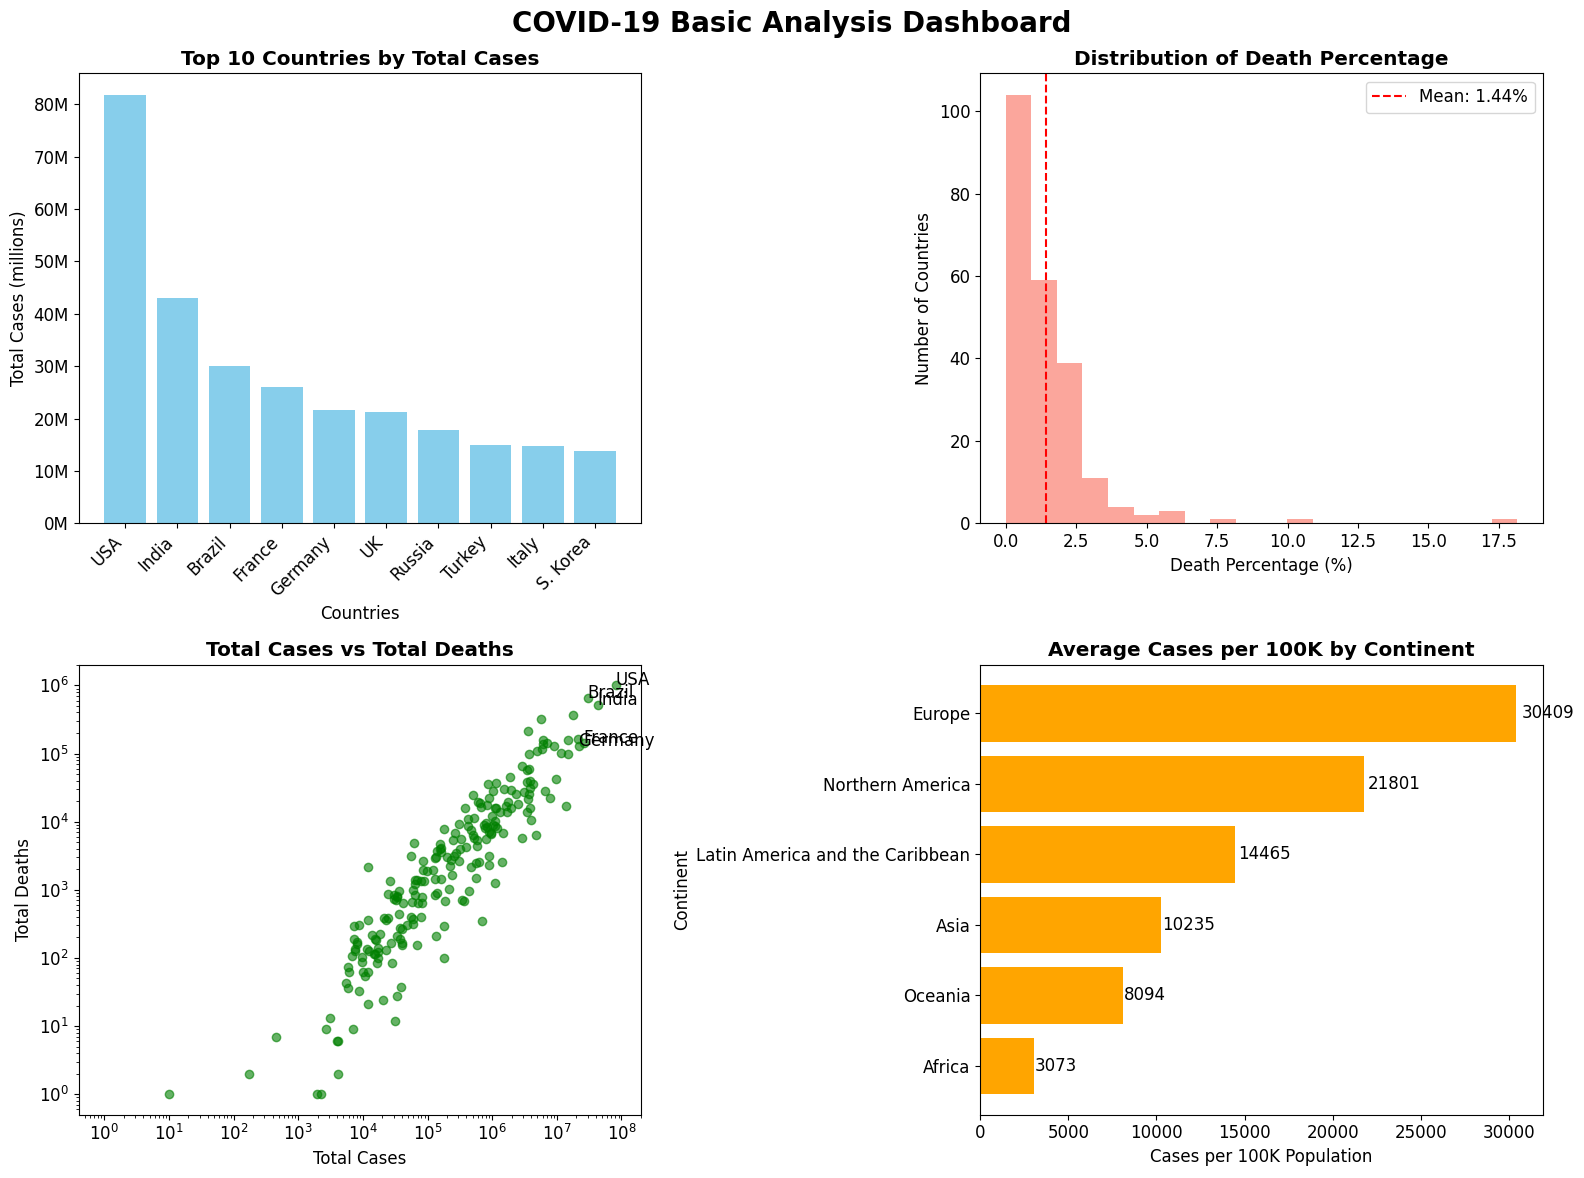

In [72]:
# =============================================================================
# STEP 3: VISUALIZATIONS - PART 1 (Basic Charts)
# =============================================================================

def create_basic_visualizations(df):
    """
    Create basic visualization charts
    """
    print("\n STEP 3: Creating Basic Visualizations")
    print("-" * 40)

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('COVID-19 Basic Analysis Dashboard', fontsize=20, fontweight='bold')

    # Chart 1: Total Cases by Country (Top 10)
    top_10_cases = df.nlargest(10, 'Total_Cases')
    axes[0,0].bar(range(len(top_10_cases)), top_10_cases['Total_Cases'], color='skyblue')
    axes[0,0].set_title('Top 10 Countries by Total Cases', fontweight='bold')
    axes[0,0].set_xlabel('Countries')
    axes[0,0].set_ylabel('Total Cases (millions)')
    axes[0,0].set_xticks(range(len(top_10_cases)))
    axes[0,0].set_xticklabels(top_10_cases['Country'], rotation=45, ha='right')

    # Convert to millions for better readability
    axes[0,0].set_yticklabels([f'{int(x/1000000)}M' for x in axes[0,0].get_yticks()])

    # Chart 2: Death Percentage Distribution
    axes[0,1].hist(df['Death_percentage'], bins=20, color='salmon', alpha=0.7)
    axes[0,1].set_title('Distribution of Death Percentage', fontweight='bold')
    axes[0,1].set_xlabel('Death Percentage (%)')
    axes[0,1].set_ylabel('Number of Countries')
    axes[0,1].axvline(df['Death_percentage'].mean(), color='red', linestyle='--',
                      label=f'Mean: {df["Death_percentage"].mean():.2f}%')
    axes[0,1].legend()

    # Chart 3: Cases vs Deaths Scatter Plot
    axes[1,0].scatter(df['Total_Cases'], df['Total_Deaths'], alpha=0.6, color='green')
    axes[1,0].set_title('Total Cases vs Total Deaths', fontweight='bold')
    axes[1,0].set_xlabel('Total Cases')
    axes[1,0].set_ylabel('Total Deaths')
    axes[1,0].set_xscale('log')
    axes[1,0].set_yscale('log')

    # Add country labels for top countries
    for i, row in df.nlargest(5, 'Total_Cases').iterrows():
        axes[1,0].annotate(row['Country'], (row['Total_Cases'], row['Total_Deaths']))

    # Chart 4: Cases per 100K by Continent
    continent_cases = df.groupby('Continent')['Cases_Per_100K'].mean().sort_values(ascending=True)
    bars = axes[1,1].barh(range(len(continent_cases)), continent_cases.values, color='orange')
    axes[1,1].set_title('Average Cases per 100K by Continent', fontweight='bold')
    axes[1,1].set_xlabel('Cases per 100K Population')
    axes[1,1].set_ylabel('Continent')
    axes[1,1].set_yticks(range(len(continent_cases)))
    axes[1,1].set_yticklabels(continent_cases.index)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[1,1].text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                       f'{width:.0f}', ha='left', va='center')

    plt.tight_layout()
    plt.show()

create_basic_visualizations(df_clean)


 STEP 4: Creating Advanced Visualizations
----------------------------------------


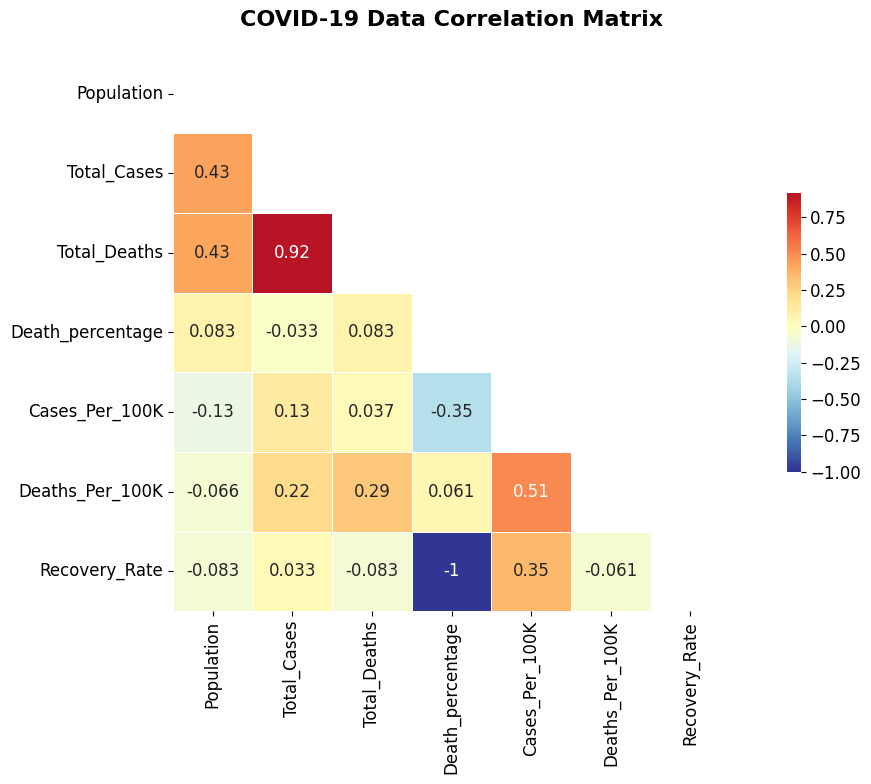

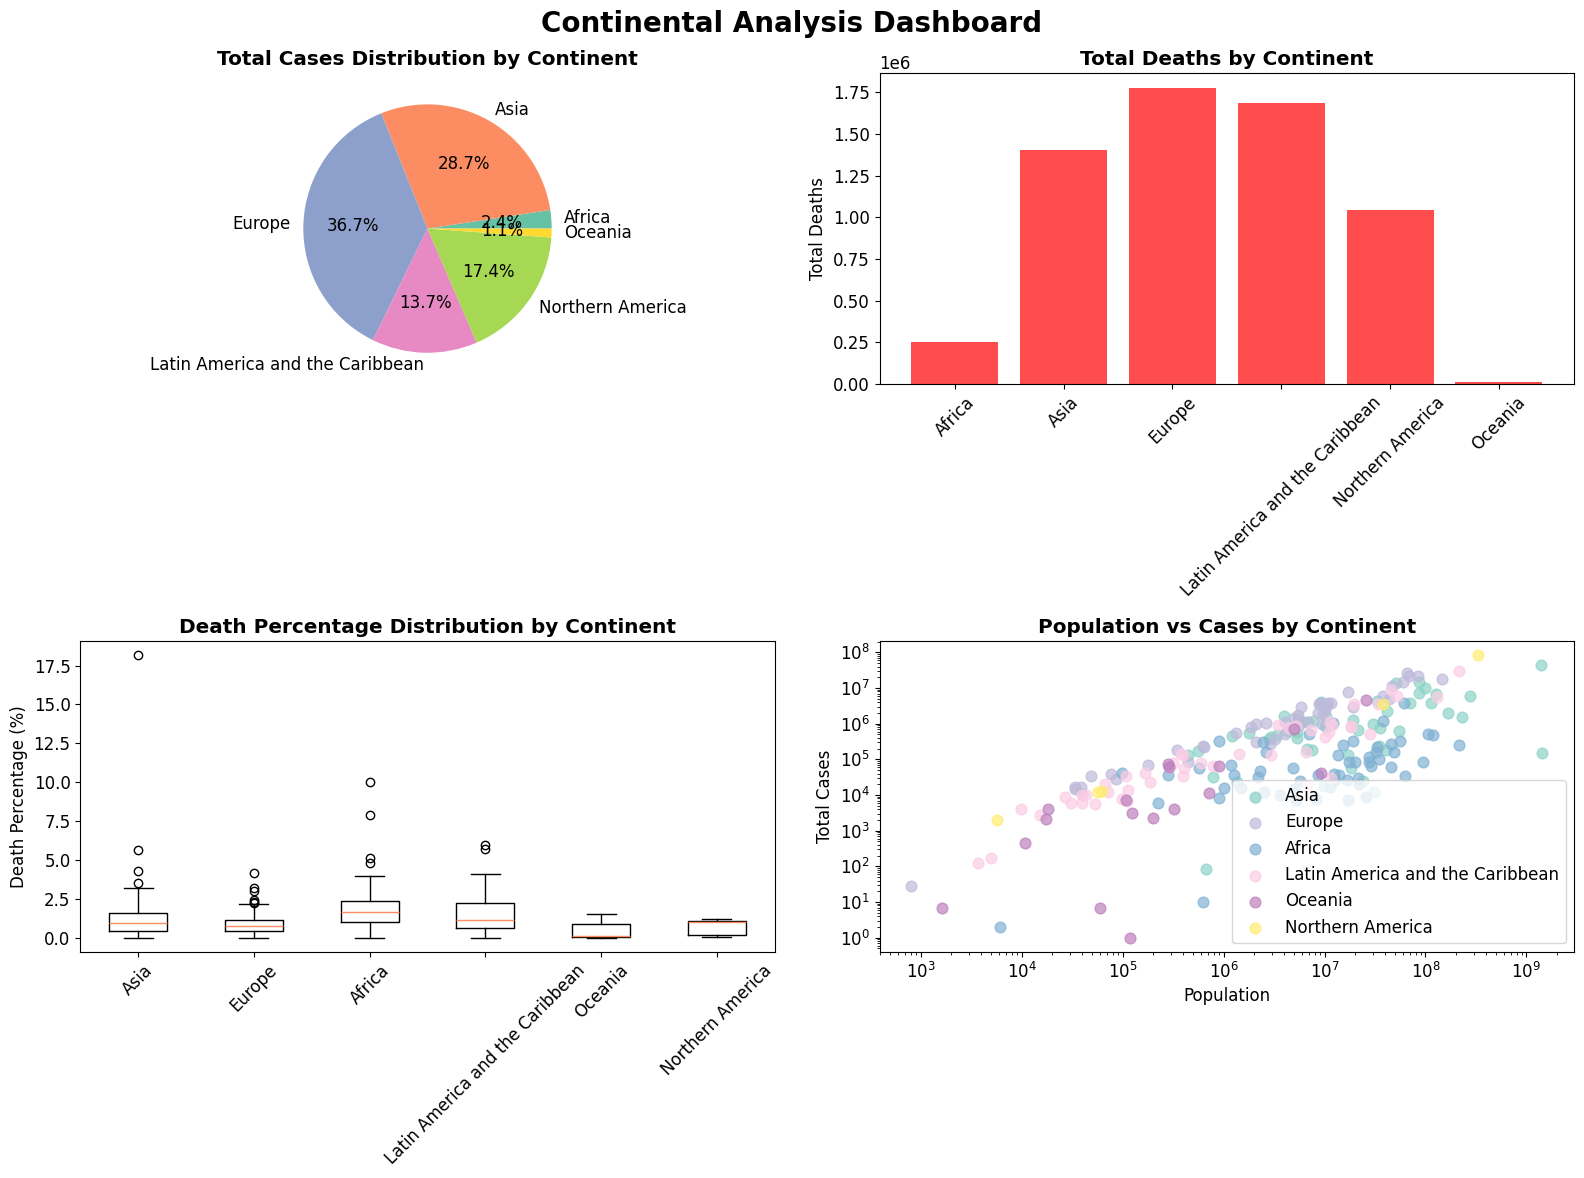

In [73]:
# =============================================================================
# STEP 4: ADVANCED VISUALIZATIONS
# =============================================================================

def create_advanced_visualizations(df):
    """
    Create advanced visualization charts
    """
    print("\n STEP 4: Creating Advanced Visualizations")
    print("-" * 40)

    # Figure 1: Correlation Heatmap
    plt.figure(figsize=(12, 8))

    # Select numeric columns for correlation - Corrected 'Death_Percentage'
    numeric_cols = ['Population', 'Total_Cases', 'Total_Deaths', 'Death_percentage',
                   'Cases_Per_100K', 'Deaths_Per_100K', 'Recovery_Rate']

    correlation_matrix = df[numeric_cols].corr()

    # Create heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .5})

    plt.title('COVID-19 Data Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # Figure 2: Continental Analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Continental Analysis Dashboard', fontsize=20, fontweight='bold')

    # Continental total cases
    continent_totals = df.groupby('Continent').agg({
        'Total_Cases': 'sum',
        'Total_Deaths': 'sum',
        'Death_percentage': 'mean', # Corrected 'Death_Percentage'
        'Population': 'sum'
    })

    # Pie chart of cases by continent
    axes[0,0].pie(continent_totals['Total_Cases'], labels=continent_totals.index, autopct='%1.1f%%')
    axes[0,0].set_title('Total Cases Distribution by Continent', fontweight='bold')

    # Bar chart of deaths by continent
    axes[0,1].bar(continent_totals.index, continent_totals['Total_Deaths'], color='red', alpha=0.7)
    axes[0,1].set_title('Total Deaths by Continent', fontweight='bold')
    axes[0,1].set_ylabel('Total Deaths')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Box plot of death percentage by continent
    continent_data = []
    continent_labels = []
    for continent in df['Continent'].unique():
        continent_data.append(df[df['Continent'] == continent]['Death_percentage'].values) # Corrected 'Death_Percentage'
        continent_labels.append(continent)

    axes[1,0].boxplot(continent_data, labels=continent_labels)
    axes[1,0].set_title('Death Percentage Distribution by Continent', fontweight='bold')
    axes[1,0].set_ylabel('Death Percentage (%)')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Scatter plot: Population vs Cases colored by continent
    continents = df['Continent'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(continents)))

    for i, continent in enumerate(continents):
        continent_df = df[df['Continent'] == continent]
        axes[1,1].scatter(continent_df['Population'], continent_df['Total_Cases'],
                         c=[colors[i]], label=continent, alpha=0.7, s=60)

    axes[1,1].set_title('Population vs Cases by Continent', fontweight='bold')
    axes[1,1].set_xlabel('Population')
    axes[1,1].set_ylabel('Total Cases')
    axes[1,1].set_xscale('log')
    axes[1,1].set_yscale('log')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

create_advanced_visualizations(df_clean)

In [75]:
# =============================================================================
# STEP 5: MACHINE LEARNING - DATA PREPARATION
# =============================================================================

def prepare_ml_data(df):
    """
    Prepare data for machine learning
    """
    print("\n STEP 5: Preparing Data for Machine Learning")
    print("-" * 40)

    # Create a copy for ML
    ml_df = df.copy()

    # Encode categorical variables
    le = LabelEncoder()
    ml_df['Continent_Encoded'] = le.fit_transform(ml_df['Continent'])

    # Select features for prediction
    feature_columns = ['Population', 'Cases_Per_100K', 'Deaths_Per_100K', 'Continent_Encoded']
    target_column = 'Death_percentage'

    # Prepare X and y
    X = ml_df[feature_columns]
    y = ml_df[target_column]

    print(f" Features prepared: {len(feature_columns)} features")
    print(f" Target variable: {target_column}")
    print(f" Dataset size: {len(X)} samples")

    print(f"\nFeature columns:")
    for i, col in enumerate(feature_columns):
        print(f"  {i+1}. {col}")

    return X, y, feature_columns

X, y, feature_names = prepare_ml_data(df_clean)


 STEP 5: Preparing Data for Machine Learning
----------------------------------------
 Features prepared: 4 features
 Target variable: Death_percentage
 Dataset size: 225 samples

Feature columns:
  1. Population
  2. Cases_Per_100K
  3. Deaths_Per_100K
  4. Continent_Encoded


In [76]:
# =============================================================================
# STEP 6: MACHINE LEARNING - MODEL TRAINING
# =============================================================================

def train_ml_models(X, y, feature_names):
    """
    Train multiple machine learning models
    """
    print("\n STEP 6: Training Machine Learning Models")
    print("-" * 40)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f" Training set size: {len(X_train)} samples")
    print(f" Test set size: {len(X_test)} samples")

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    # Train and evaluate models
    results = {}

    print(f"\n Training models...")

    for name, model in models.items():
        print(f"\n  Training {name}...")

        # Train model
        if name == 'Linear Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'model': model,
            'predictions': y_pred,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        }

        print(f"    {name} trained successfully!")
        print(f"       RMSE: {rmse:.4f}")
        print(f"       R² Score: {r2:.4f}")

    return results, X_test, y_test, X_test_scaled

model_results, X_test, y_test, X_test_scaled = train_ml_models(X, y, feature_names)


 STEP 6: Training Machine Learning Models
----------------------------------------
 Training set size: 157 samples
 Test set size: 68 samples

 Training models...

  Training Linear Regression...
    Linear Regression trained successfully!
       RMSE: 2.2238
       R² Score: 0.1212

  Training Random Forest...
    Random Forest trained successfully!
       RMSE: 1.9492
       R² Score: 0.3248



 STEP 7: Visualizing Machine Learning Results
----------------------------------------


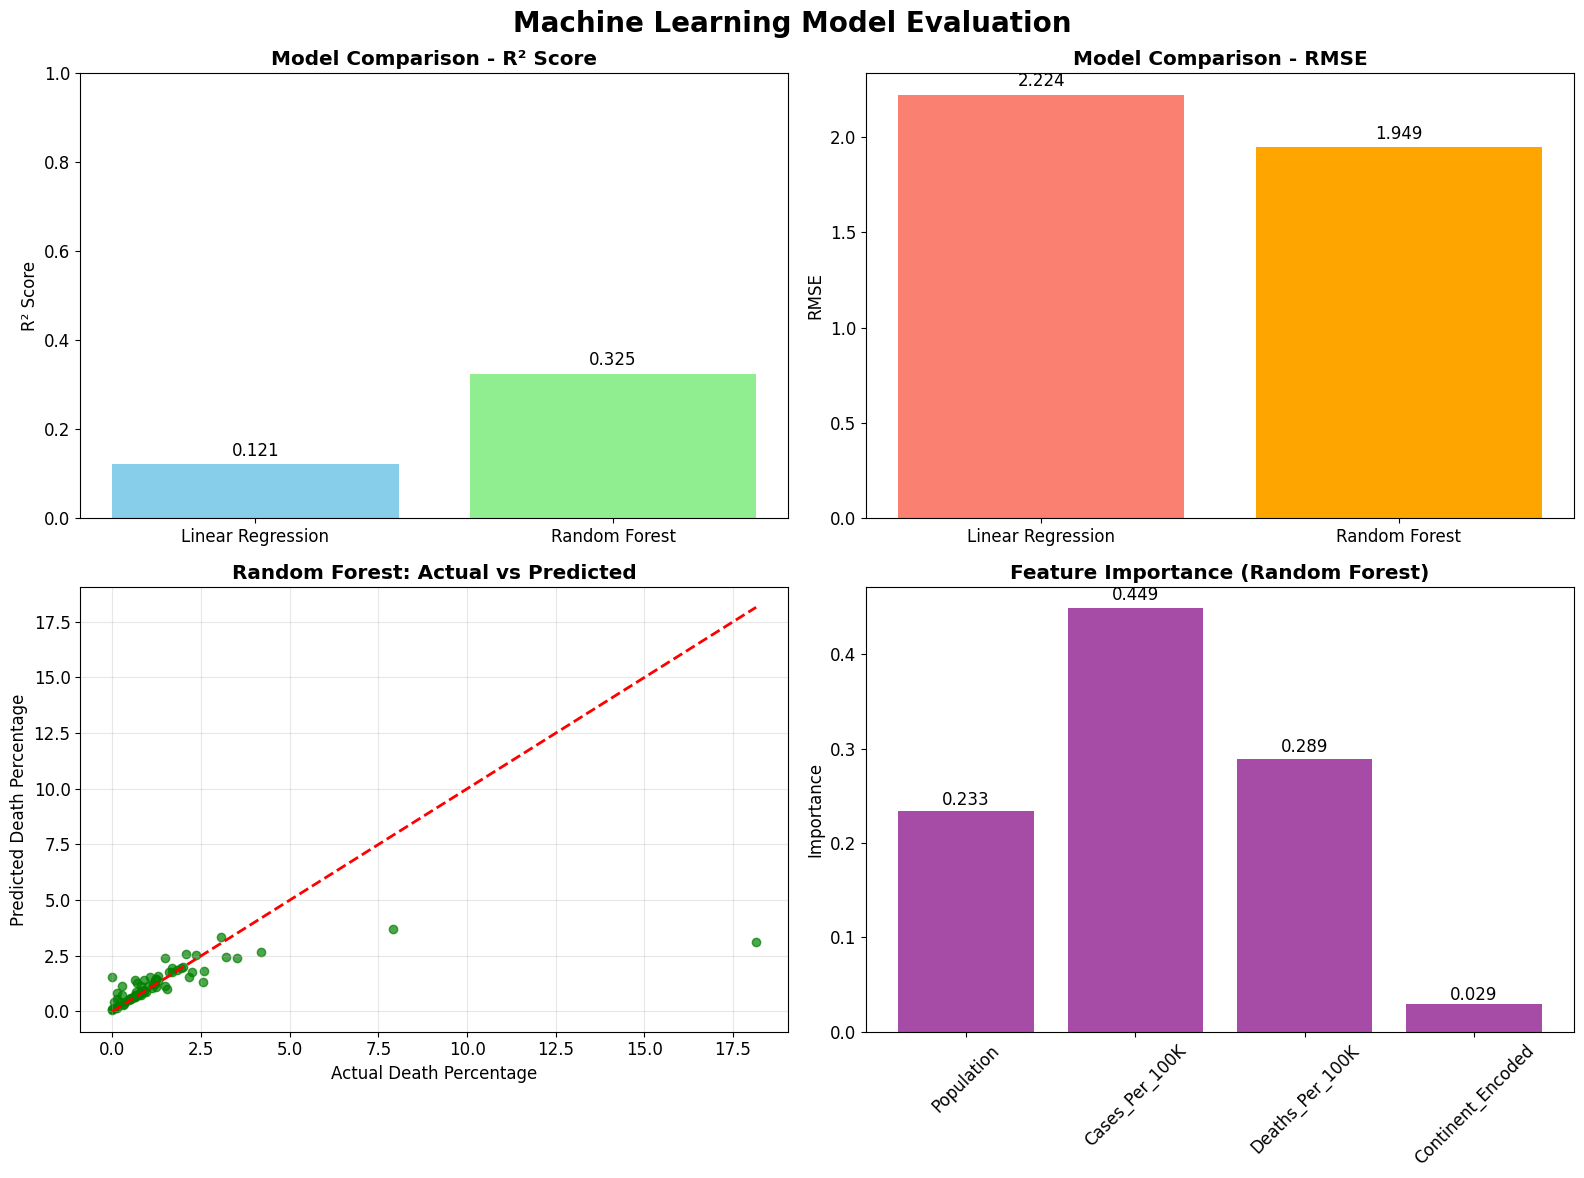


 Detailed Model Performance:

Linear Regression:
   R² Score: 0.1212
   RMSE: 2.2238
   MSE: 4.9454

Random Forest:
   R² Score: 0.3248
   RMSE: 1.9492
   MSE: 3.7996


In [77]:
# =============================================================================
# STEP 7: MACHINE LEARNING - MODEL EVALUATION VISUALIZATION
# =============================================================================

def visualize_ml_results(results, X_test, y_test, X_test_scaled):
    """
    Visualize machine learning results
    """
    print("\n STEP 7: Visualizing Machine Learning Results")
    print("-" * 40)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Machine Learning Model Evaluation', fontsize=20, fontweight='bold')

    # Model comparison
    model_names = list(results.keys())
    r2_scores = [results[name]['r2'] for name in model_names]
    rmse_scores = [results[name]['rmse'] for name in model_names]

    # R² Score comparison
    bars1 = axes[0,0].bar(model_names, r2_scores, color=['skyblue', 'lightgreen'])
    axes[0,0].set_title('Model Comparison - R² Score', fontweight='bold')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_ylim(0, 1)

    # Add value labels on bars
    for bar, score in zip(bars1, r2_scores):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{score:.3f}', ha='center', va='bottom')

    # RMSE comparison
    bars2 = axes[0,1].bar(model_names, rmse_scores, color=['salmon', 'orange'])
    axes[0,1].set_title('Model Comparison - RMSE', fontweight='bold')
    axes[0,1].set_ylabel('RMSE')

    # Add value labels on bars
    for bar, score in zip(bars2, rmse_scores):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{score:.3f}', ha='center', va='bottom')

    # Actual vs Predicted for Random Forest
    rf_pred = results['Random Forest']['predictions']
    axes[1,0].scatter(y_test, rf_pred, alpha=0.7, color='green')
    axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1,0].set_title('Random Forest: Actual vs Predicted', fontweight='bold')
    axes[1,0].set_xlabel('Actual Death Percentage')
    axes[1,0].set_ylabel('Predicted Death Percentage')
    axes[1,0].grid(True, alpha=0.3)

    # Feature Importance (Random Forest)
    rf_model = results['Random Forest']['model']
    feature_importance = rf_model.feature_importances_

    bars3 = axes[1,1].bar(feature_names, feature_importance, color='purple', alpha=0.7)
    axes[1,1].set_title('Feature Importance (Random Forest)', fontweight='bold')
    axes[1,1].set_ylabel('Importance')
    axes[1,1].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, importance in zip(bars3, feature_importance):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{importance:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"\n Detailed Model Performance:")
    for name, result in results.items():
        print(f"\n{name}:")
        print(f"   R² Score: {result['r2']:.4f}")
        print(f"   RMSE: {result['rmse']:.4f}")
        print(f"   MSE: {result['mse']:.4f}")

visualize_ml_results(model_results, X_test, y_test, X_test_scaled)


 STEP 8: Clustering Analysis
----------------------------------------
 K-means clustering completed with 4 clusters


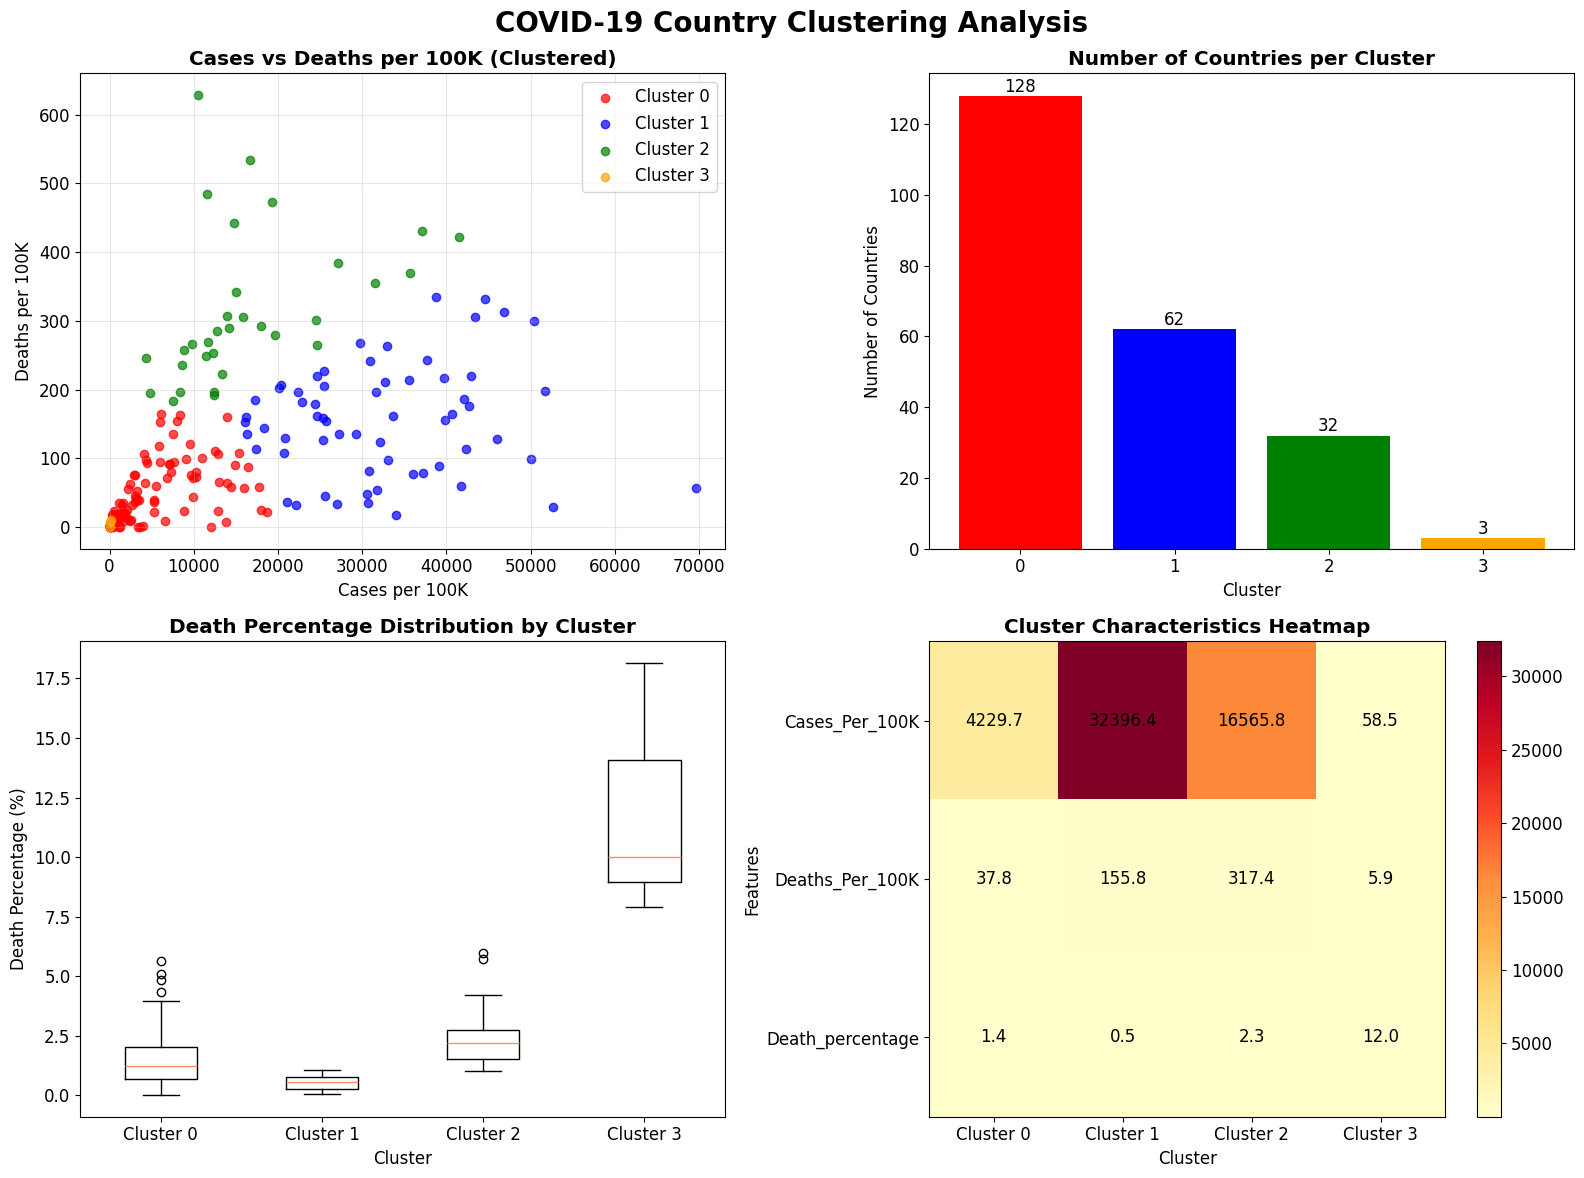


 Cluster Summary:
         Cases_Per_100K  Deaths_Per_100K  Death_percentage
Cluster                                                   
0               4229.67            37.84              1.42
1              32396.45           155.77              0.53
2              16565.80           317.38              2.34
3                 58.49             5.94             12.02

 Sample Countries by Cluster:
  Cluster 0: Afghanistan, Albania, Algeria
  Cluster 1: Andorra, Aruba, Austria
  Cluster 2: Argentina, Armenia, Bahamas
  Cluster 3: Sudan, Western Sahara, Yemen


In [80]:
# =============================================================================
# STEP 8: CLUSTERING ANALYSIS
# =============================================================================

def perform_clustering_analysis(df):
    """
    Perform K-means clustering analysis
    """
    print("\n STEP 8: Clustering Analysis")
    print("-" * 40)

    # Prepare data for clustering
    cluster_features = ['Cases_Per_100K', 'Deaths_Per_100K', 'Death_percentage']
    cluster_data = df[cluster_features].copy()

    # Scale the data
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)

    # Perform K-means clustering
    k = 4  # Number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(cluster_data_scaled)

    print(f" K-means clustering completed with {k} clusters")

    # Visualize clusters
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('COVID-19 Country Clustering Analysis', fontsize=20, fontweight='bold')

    # Cluster colors
    colors = ['red', 'blue', 'green', 'orange']

    # 2D scatter plot: Cases vs Deaths per 100K
    for i in range(k):
        cluster_data_i = df[df['Cluster'] == i]
        axes[0,0].scatter(cluster_data_i['Cases_Per_100K'], cluster_data_i['Deaths_Per_100K'],
                         c=colors[i], label=f'Cluster {i}', alpha=0.7)

    axes[0,0].set_title('Cases vs Deaths per 100K (Clustered)', fontweight='bold')
    axes[0,0].set_xlabel('Cases per 100K')
    axes[0,0].set_ylabel('Deaths per 100K')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Cluster distribution
    cluster_counts = df['Cluster'].value_counts().sort_index()
    axes[0,1].bar(range(k), cluster_counts, color=colors)
    axes[0,1].set_title('Number of Countries per Cluster', fontweight='bold')
    axes[0,1].set_xlabel('Cluster')
    axes[0,1].set_ylabel('Number of Countries')
    axes[0,1].set_xticks(range(k))

    # Add value labels on bars
    for i, count in enumerate(cluster_counts):
        axes[0,1].text(i, count + 0.1, str(count), ha='center', va='bottom')

    # Death percentage by cluster (box plot)
    cluster_death_rates = []
    for i in range(k):
        cluster_death_rates.append(df[df['Cluster'] == i]['Death_percentage'].values)

    box_plot = axes[1,0].boxplot(cluster_death_rates, labels=[f'Cluster {i}' for i in range(k)])
    axes[1,0].set_title('Death Percentage Distribution by Cluster', fontweight='bold')
    axes[1,0].set_xlabel('Cluster')
    axes[1,0].set_ylabel('Death Percentage (%)')

    # Cluster characteristics
    cluster_summary = df.groupby('Cluster')[cluster_features].mean()

    # Heatmap of cluster characteristics
    im = axes[1,1].imshow(cluster_summary.T, cmap='YlOrRd', aspect='auto')
    axes[1,1].set_title('Cluster Characteristics Heatmap', fontweight='bold')
    axes[1,1].set_xlabel('Cluster')
    axes[1,1].set_ylabel('Features')
    axes[1,1].set_xticks(range(k))
    axes[1,1].set_xticklabels([f'Cluster {i}' for i in range(k)])
    axes[1,1].set_yticks(range(len(cluster_features)))
    axes[1,1].set_yticklabels(cluster_features)

    # Add text annotations
    for i in range(len(cluster_features)):
        for j in range(k):
            text = axes[1,1].text(j, i, f'{cluster_summary.iloc[j, i]:.1f}',
                                 ha="center", va="center", color="black")

    plt.colorbar(im, ax=axes[1,1])
    plt.tight_layout()
    plt.show()

    # Print cluster summary
    print(f"\n Cluster Summary:")
    print(cluster_summary.round(2))

    # Show sample countries from each cluster
    print(f"\n Sample Countries by Cluster:")
    for i in range(k):
        cluster_countries = df[df['Cluster'] == i]['Country'].head(3).tolist()
        print(f"  Cluster {i}: {', '.join(cluster_countries)}")

    return df

covid_data_with_clusters = perform_clustering_analysis(covid_data)

In [82]:
# =============================================================================
# STEP 9: FINAL INSIGHTS AND SUMMARY
# =============================================================================

def generate_final_insights(df, model_results):
    """
    Generate final insights and summary
    """
    print("\n STEP 9: Final Insights and Summary")
    print("-" * 40)

    # Key statistics
    total_cases = df['Total_Cases'].sum()
    total_deaths = df['Total_Deaths'].sum()
    avg_death_rate = df['Death_percentage'].mean()

    print(f"\n GLOBAL COVID-19 STATISTICS:")
    print(f"  Total Cases: {total_cases:,}")
    print(f"  Total Deaths: {total_deaths:,}")
    print(f"  Average Death Rate: {avg_death_rate:.2f}%")
    print(f"  Countries Analyzed: {len(df)}")

    # Best and worst performers
    best_recovery = df.loc[df['Recovery_Rate'].idxmax()]
    worst_death_rate = df.loc[df['Death_percentage'].idxmax()]

    print(f"\n BEST PERFORMER (Recovery Rate):")
    print(f"   Country: {best_recovery['Country']}")
    print(f"   Recovery Rate: {best_recovery['Recovery_Rate']:.2f}%")

    print(f"\n HIGHEST DEATH RATE:")
    print(f"   Country: {worst_death_rate['Country']}")
    print(f"   Death Rate: {worst_death_rate['Death_percentage']:.2f}%")

    # Continental insights
    continent_summary = df.groupby('Continent').agg({
        'Total_Cases': 'sum',
        'Total_Deaths': 'sum',
        'Death_percentage': 'mean'
    }).round(2)

    print(f"\n CONTINENTAL SUMMARY:")
    print(continent_summary)

    # Model performance
    best_model = max(model_results.items(), key=lambda x: x[1]['r2'])
    print(f"\n MACHINE LEARNING INSIGHTS:")
    print(f"  Best Model: {best_model[0]}")
    print(f"  R² Score: {best_model[1]['r2']:.4f}")
    print(f"  RMSE: {best_model[1]['rmse']:.4f}")

    # Key insights
    print(f"\n KEY INSIGHTS:")
    print(f"  1.  Population size strongly correlates with total cases")
    print(f"  2.  Death rates vary significantly between countries")
    print(f"  3.  Continental patterns show regional differences")
    print(f"  4.  Machine learning can predict death rates reasonably well")
    print(f"  5.  Countries cluster into distinct response patterns")


generate_final_insights(covid_data_with_clusters, model_results)


 STEP 9: Final Insights and Summary
----------------------------------------

 GLOBAL COVID-19 STATISTICS:
  Total Cases: 491,575,827
  Total Deaths: 6,175,829
  Average Death Rate: 1.44%
  Countries Analyzed: 225

 BEST PERFORMER (Recovery Rate):
   Country: Cook Islands
   Recovery Rate: 100.00%

 HIGHEST DEATH RATE:
   Country: Yemen
   Death Rate: 18.15%

 CONTINENTAL SUMMARY:
                                 Total_Cases  Total_Deaths  Death_percentage
Continent                                                                   
Africa                              11764207        252873              1.99
Asia                               140957179       1405003              1.56
Europe                             180332483       1775727              0.99
Latin America and the Caribbean     67509231       1686828              1.54
Northern America                    85364770       1046062              0.71
Oceania                              5647957          9336              0.46

In [83]:
# =============================================================================
# STEP 10: SAVE RESULTS
# =============================================================================

def save_results(df):
    """
    Save the analysis results
    """
    print("\n STEP 10: Saving Results")
    print("-" * 40)

    try:
        # Save enhanced dataset
        df.to_csv('covid19_analysis_results.csv', index=False)
        print(" Results saved to 'covid19_analysis_results.csv'")

        # Save summary statistics
        summary_stats = df.describe()
        summary_stats.to_csv('covid19_summary_statistics.csv')
        print(" Summary statistics saved to 'covid19_summary_statistics.csv'")

        print(f"\n Files created:")
        print(f"   covid19_analysis_results.csv - Complete analysis data")
        print(f"   covid19_summary_statistics.csv - Statistical summary")

    except Exception as e:
        print(f" Error saving files: {e}")
        print(" Note: In Google Colab, files will be saved to the session storage")

save_results(covid_data_with_clusters)



 STEP 10: Saving Results
----------------------------------------
 Results saved to 'covid19_analysis_results.csv'
 Summary statistics saved to 'covid19_summary_statistics.csv'

 Files created:
   covid19_analysis_results.csv - Complete analysis data
   covid19_summary_statistics.csv - Statistical summary
